In [57]:

import os
import re
import cv2
import numpy as np
from random import choice, randint
from natsort import natsorted
from skimage.feature import hog
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [58]:

def extract_features(path, img_size=(45, 45)):
    features, targets = [], []
    label_map = []
    subdirs = natsorted(next(os.walk(path))[1])
    for idx, sub in enumerate(subdirs):
        current_path = os.path.join(path, sub)
        label_map.append(sub)
        images = natsorted(next(os.walk(current_path))[2])[:100]
        for img_name in images:
            img = cv2.imread(os.path.join(current_path, img_name))
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            norm = img / 255.0
            clahe_img = cv2.createCLAHE(2.0, (8,8)).apply((norm * 255).astype(np.uint8))
            features.append(hog(clahe_img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm="L2-Hys"))
            targets.append(idx)
    return features, targets, label_map


In [59]:

def load_test_images(test_dir, img_size=(45, 45)):
    data = []
    files = natsorted(next(os.walk(test_dir))[2])
    for f in files:
        img = cv2.imread(os.path.join(test_dir, f))
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        norm = img / 255.0
        clahe_img = cv2.createCLAHE(2.0, (8,8)).apply((norm * 255).astype(np.uint8))
        data.append(hog(clahe_img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm="L2-Hys"))
    return data

def classify(model, data):
    return model.predict(data)

def assemble_string(predictions, labels):
    return ''.join([labels[i] for i in predictions])

def validate_expression(s):
    return re.fullmatch(r"(\(\d+(?:[+\-*]|times)\d+\)|\d+(?:[+\-*]|times)\d+)", s)



In [60]:

def read_raw_images(path, img_size=(45, 45)):
    images = []
    files = natsorted(next(os.walk(path))[2])
    for f in files:
        img = cv2.imread(os.path.join(path, f))
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        norm = img / 255.0
        images.append(norm)
    return images


In [62]:

data_path = "D:/mfti/python/second/HT3/data"
X, y, labels = extract_features(data_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

opt = {"acc": -1}
for w in ["uniform", "distance"]:
    for m in ["minkowski", "cosine", "euclidean"]:
        for k in range(2, 60):
            model = Pipeline([
                ("scale", StandardScaler()),
                ("knn", KNeighborsClassifier(n_neighbors=k, weights=w, metric=m))
            ])
            model.fit(X_train, y_train)
            score = accuracy_score(y_val, model.predict(X_val))
            if score > opt["acc"]:
                opt = {"acc": score, "weight": w, "metric": m, "k": k}
acc = opt["acc"]
print(f"Точность модели kNN: {acc * 100:.2f}%")

Точность модели kNN: 80.95%


In [63]:

final_model = Pipeline([
    ("scale", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=opt["k"], weights=opt["weight"], metric=opt["metric"]))
])
final_model.fit(X_train, y_train)


Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(metric='cosine', n_neighbors=9,
                                      weights='distance'))])

In [64]:
from random import randint, choice, random

operators = ["+", "-", "times"]
use_parentheses = random() < 0.5

a = str(randint(0, 9))
b = str(randint(0, 9))
op = choice(operators)

if use_parentheses:
    chosen_expr = ["(", a, op, b, ")"]
else:
    chosen_expr = [a, op, b]

print(chosen_expr)



['(', '6', '+', '8', ')']


(6+8)


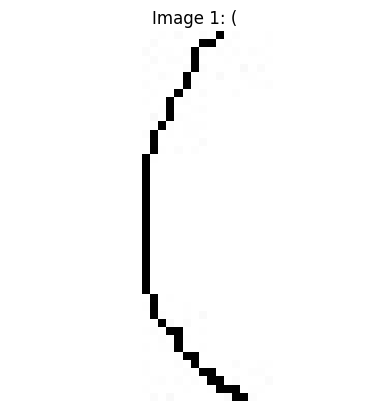

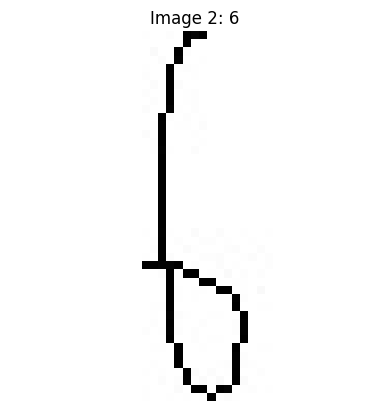

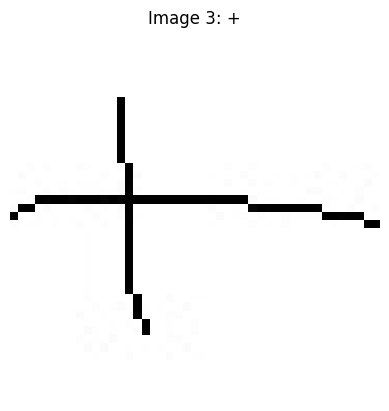

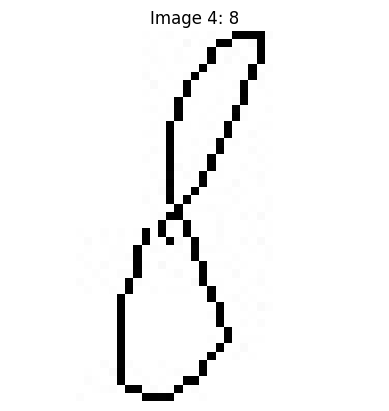

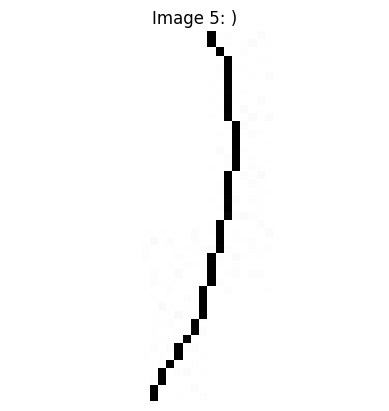

In [78]:
random_test_files = [os.path.join(data_path, c) for c in chosen_expr]
selected_imgs = []
selected_imgs_for_display = []

for folder in random_test_files:
    imgs = natsorted(next(os.walk(folder))[2])
    selected = choice(imgs)
    full_path = os.path.join(folder, selected)
    img = cv2.imread(full_path)
    img_resized = cv2.resize(img, (45, 45))
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    norm = img_gray / 255.0
    clahe_img = cv2.createCLAHE(2.0, (8,8)).apply((norm * 255).astype(np.uint8))
    feat = hog(clahe_img, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2), block_norm="L2-Hys")
    selected_imgs.append(feat)
    selected_imgs_for_display.append(img_resized)


result = classify(final_model, selected_imgs)
expr_str = assemble_string(result, labels)
print(expr_str)

for i, img in enumerate(selected_imgs_for_display):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}: {chosen_expr[i]}")
    plt.axis('off')
    plt.show()

In [79]:

if validate_expression(expr_str):
    print("Correct!")
    print(eval(expr_str))
else:
    print("Incorrect!")


Correct!
14


In [84]:
def bit_pattern_scan(imgs, mask=(5, 5)):
    full_img = cv2.hconcat(imgs)
    res = ''
    for y in range(0, full_img.shape[0], mask[0]):
        for x in range(0, full_img.shape[1], mask[1]):
            block = full_img[y:y + mask[0], x:x + mask[1]]
            mean = block.mean()
            res += '1' if mean >= 1 else '0'
    return len(re.findall("010", res))


raw_imgs = read_raw_images("D:/mfti/python/second/HT3/data/0")
pattern_matches = bit_pattern_scan(raw_imgs)
print("Найдено совпадений:", pattern_matches)


Найдено совпадений: 26728


In [86]:
def image_to_binary_string(img, threshold=0.5):
    binary_string = ""
    for row in img:
        for pixel in row:
            binary_string += '1' if pixel < threshold else '0'
        binary_string += '\n'
    return binary_string

# Используем первое изображение из набора
binary_img = image_to_binary_string(raw_imgs[0])
print(binary_img)


000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000
000000000000000000000000000111111111111000000
000000000000000000000000011000000000000100000
000000000000000000000001100000000000000100000
000000000000000000000010000000000000000010000
000000000000000000001100000000000000000001000
000000000000000000110000000000000000000001000
000000000000000001000000000000000000000000100
000000000000000110000000000000000000000000010
000000000000011000000000000000000000000000010
000000000000100000000000000000000000000000001
000000100001000000000000000000000000000000001
000000100010000000000000000000000000000000001
000000100100000000000000000000000000000000001
000000101000000000000000000000000000000000001
000001010000000000000000000000000000000000001
000001100000000000000000000000000000000000001
000001100000000000000000000000000000000000001
0000010000000000000000000000000000